In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque

tf.keras.utils.disable_interactive_logging()

2024-11-17 16:01:24.834232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 16:01:28.152836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2024-11-17 16:01:28.153898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

#### Basic Reinforced learning

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()[0]
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated ,info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [4]:
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

42.352 9.00866782604398 25.0 72.0


In [5]:
frames = []
obs = env.reset()[0]
for step in range(200):
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    if truncated:
        break

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.show()
    return anim

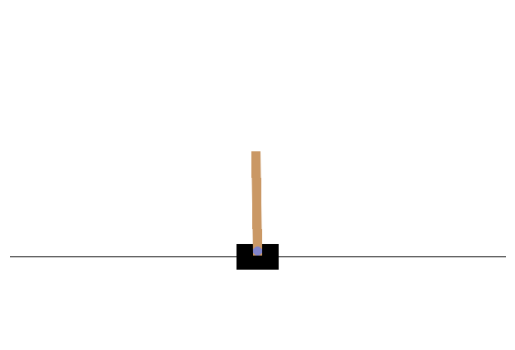

In [7]:
plot_animation(frames)

In [8]:
n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="selu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])


2024-08-22 10:26:20.695770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 10:26:20.723510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 10:26:20.723588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 10:26:20.724499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [9]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1",render_mode="rgb_array")
    np.random.seed(seed)
    obs = env.reset()[0]
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs[np.newaxis])
        action = int(np.random.rand() > left_proba)
        obs, reward, terminated, truncated, info = env.step(action)
        print(reward)
        if truncated:
            break
    env.close
    return frames

In [10]:
frames = render_policy_net(model)

1/1 [==============================] - 0s 114ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 22ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 18ms/

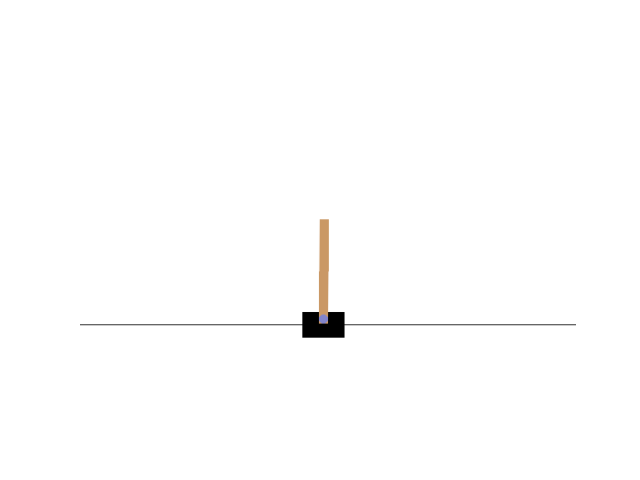

In [11]:
# plot_animation(frames)

In [12]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1",render_mode="rgb_array") for _ in range(n_environments)]
observations = [env.reset()[0] for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = [[1.] if obs[2] < 0 else [0.] for obs in observations]
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"\rIteration: {iteration}, Loss: {loss}", end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, terminated, truncated, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not truncated else env.reset()[0]

for env in envs:
    env.close()

Iteration: 0, Loss: 0.6965591311454773

2024-08-22 10:26:31.818962: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d755ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-22 10:26:31.819010: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-08-22 10:26:31.828537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 10:26:31.950147: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 4999, Loss: 5.402520346511086e-228

In [13]:
frames = render_policy_net(model)

1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 15ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1/1 [==============================] - 0s 16ms/step
1.0
1/1 [==============================] - 0s 16ms/s

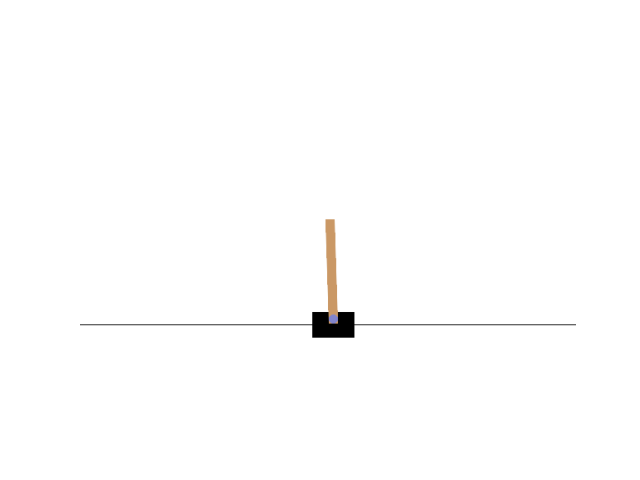

In [14]:
plot_animation(frames)

#### Policy Gradient

In [2]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, grads

In [3]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [4]:

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [5]:

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [6]:

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

2024-08-22 14:13:51.226447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 14:13:51.250062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 14:13:51.250145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-22 14:13:51.252271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [7]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [8]:
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                    
    print("\rIteration: {}, mean rewards: {:.1f}".format(    
        iteration, total_rewards / n_episodes_per_update), end="") 
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 0, mean rewards: 23.9

2024-08-22 14:13:53.758428: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xbb51160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-22 14:13:53.758484: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-08-22 14:13:53.763962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 14:13:53.873082: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 100, mean rewards: 178.1

KeyboardInterrupt: 

#### Markov Decision Process

In [26]:
decision_probability = [
                        [[0.7, 0.3, 0.0],[1.0, 0.0, 0.0],[0.8, 0.2, 0.0]],
                        [[1.0, 0.0, 0.0],None,[1.0, 0.0, 0.0]],
                        [None,[0.8, 0.1, 0.1],None]
                       ]
rewards = [
           [[+10, 0, 0],[0, 0, 0],[0, 0, 0]],
           [[0,0,0],[0,0,0],[-50,0,0]],
           [[0, 0,0],[+40,0,0],[0,0,0]]
          ]
actions = [[0,1,2],[0,2],[1]]

In [27]:
q_values = np.full((3,3), -np.inf)
for state, action in enumerate(actions):
    q_values[state, action] = 0.0

#### Value Iteration

In [28]:
# Q-Values

discount_factor = 0.90
history = []
for iteration in range(50):
    q_copy = q_values.copy()
    history.append(q_copy)
    for state in range(3):
        for action in actions[state]:
            q_values[state,action] = np.sum(
                [decision_probability[state][action][prob] * (rewards[state][action][prob] + discount_factor * np.max(q_copy[prob])) 
                 for prob in range(3)])

In [29]:
# Q-Learning
np.random.seed(42)

q_values = np.full((3,3), -np.inf)
for state,action in enumerate(actions):
    q_values[state][action] = 0


state = 0
decay = 0.005
gamma = 0.90
alpha0 = 0.05
history_2 = []

def step(state, action):
    proba = decision_probability[state][action]
    next_state = np.random.choice([0,1,2],p=proba)
    reward = rewards[state][action][next_state]
    return next_state, reward

def behavior_policy(state):
    return np.random.choice(actions[state])

for iteration in range(10000):
    action = behavior_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    q_values[state, action] += alpha * (reward + gamma * next_value - q_values[state,action])
    state = next_state
    


In [30]:
q_values

array([[ 31.87582798,  27.56123705,  25.72218961],
       [ 22.30542745,         -inf, -25.42866125],
       [        -inf,   0.        ,         -inf]])

#### Basic DQN

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

input_shape = [4]
output = 2

model = keras.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(output)
])


2024-10-14 13:38:42.866935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 13:38:42.888822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 13:38:42.888882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 13:38:42.889921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [3]:
def greedy_policy(state, epsilon=0):
    """
    
    """
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        q_values = model.predict(state[np.newaxis])
        return np.argmax(q_values[0])

In [4]:
# replay buffer
from collections import deque

replay_buffer = deque(maxlen=2000)

In [5]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in batch])for field_index in range(5)] 
    return  states, actions, rewards, next_states, dones

In [6]:
def play_one_step(env, state, epsilon):
    done = 0
    action = greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        done = 1
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [7]:
loss_fn = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
batch_size = 32
discount_rate = 0.95


def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_q_values = model.predict(next_states)
    max_next_q_values = np.max(next_q_values, axis=1)
    target_q_values = (max_next_q_values * discount_rate * (1 - dones) + rewards)
    target_q_values = target_q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, output)
    
    with tf.GradientTape() as tape:
        q_values = model(states)
        q_values = tf.reduce_sum(q_values * mask, axis=-1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_q_values, q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [ ]:
epsilon = 1
n_episodes = 200
n_steps = 200

rewards = []
best_score = 0

for episode in range(n_episodes):
    obs, _ = env.reset()    # state_0
    epsilon = max(1 - episode / 500, 0.01)
    for step in range(n_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_score = step
        best_weights = model.get_weights()

    print("Episode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

1/1 [==============================] - 0s 18ms/step


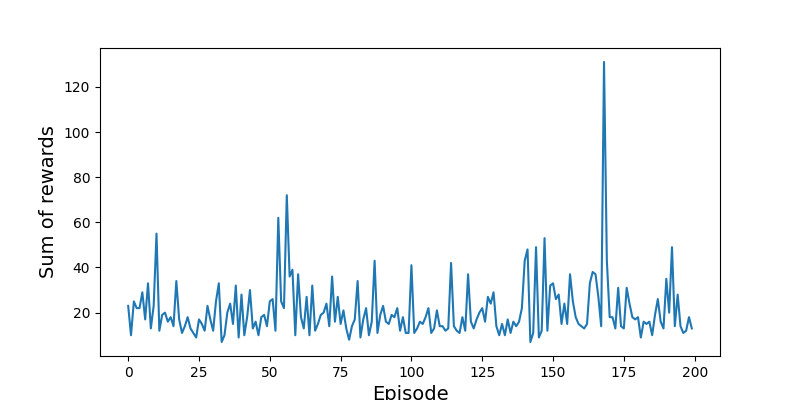

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

#### Double DQN

In [40]:
n_inputs = 4
n_outputs = 2

model = keras.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

In [41]:
def sample_experiences(batch_size):
    # replay_memory (s,a,r,s`,d)
    rnd_indices = np.random.randint(len(replay_memory), size=batch_size)
    samples = [replay_memory[index] for index in rnd_indices]
    states, actions, rewards, next_states, dones = [np.array([sample[index] for sample in samples]) for index in range(5)]
    return states, actions, rewards, next_states, dones

In [ ]:
batch_size = 32


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_state_q_values = model.predict(next_states)
    max_next_state = np.argmax(next_state_q_values, axis=-1)
    next_mask = tf.one_hot(max_next_state,n_outputs).numpy()
    max_target_q_values = (target_model.predict(next_states) * next_mask).sum(axis=-1)
    max_targat_q_values = (rewards + (1 - dones) * discount_factor * max_target_q_values)

    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        q_values = model(states)
        q_values = tf.reduce_sum(q_values * mask, axis=-1)
        loss = tf.reduce_mean(loss_fn(max_target_q_values, q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    

#### Prioritized Experience Replay

In [3]:
class SumTree():
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.tree = np.zeros(buffer_size * 2 - 1)
        self.data = np.zeros(buffer_size, dtype=object)
        self.index = 0

    def add(self, priority, experience):
        tree_index = self.index + self.buffer_size - 1
        self.data[self.index] = experience

        self.update(priority, tree_index)
        self.index = (self.index + 1) % self.buffer_size
        
    def update(self, priority, tree_index):
        """
        update to new priority and propagate the tree
        """
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        self._propagate(change, tree_index)

    def _propagate(self, change, tree_index):
        parent_index = (tree_index - 1) // 2
        self.tree[parent_index] += change
        if parent_index != 0:
            self._propagate(change, parent_index)    
            
    def sample(self, s):
        index = self._retrieve(0, s)
        data_index = index - self.buffer_size + 1
        return index, self.tree[index], self.data[data_index]

    def _retrieve(self, index, s):
        left_index = (index * 2) + 1
        right_index = left_index + 1
        if left_index >= len(self.tree):
            return index
        if s <= self.tree[left_index]:
            return self._retrieve(left_index, s)
        else:
            return self._retrieve(right_index, s - self.tree[left_index])

    def get_root(self):
        return self.tree[0]
    
    def view_tree(self):
        print(self.tree)

#### Double Dueling DQN

In [3]:
keras.backend.clear_session()
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [4]:
K = keras.backend
n_inputs = 4
n_outputs = 2

replay_memory = deque(maxlen=2000)


input_layer = keras.Input(shape=[4])
hidden_1 = keras.layers.Dense(32, activation="elu")(input_layer)
hidden_2 = keras.layers.Dense(32, activation="elu")(hidden_1)
state_values = keras.layers.Dense(1)(hidden_2)
raw_advantages = keras.layers.Dense(2)(hidden_2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
q_values = state_values + advantages

model = keras.models.Model(inputs=[input_layer], outputs=[q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

2024-10-31 10:09:59.589161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:09:59.627721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:09:59.627776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:09:59.628985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [5]:
def greedy_policy(state, epsilon=0):
    n_rnd = np.random.rand()
    if n_rnd < epsilon:
        return np.random.randint(2)
    else:
        q_values = model.predict(state[np.newaxis])
        return np.argmax(q_values[0])

In [6]:
def play_one_step(env, state, epsilon):
    action = greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done


In [7]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    experiences = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in experiences])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [8]:
batch_size = 32
discount_factor = 0.95

optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    t_q_value = model.predict(next_states)
    t_mask = tf.one_hot(np.argmax(t_q_value, axis=1), n_outputs).numpy()
    max_t_q_value = (target.predict(next_states) * t_mask).sum(axis=1)
    max_t_q_value = (max_t_q_value * discount_factor * (1 - dones) + rewards)
    max_t_q_value = max_t_q_value.reshape(-1, 1)
    q_mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        q_values = model(states)
        q_values = tf.reduce_sum(q_values * q_mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(max_t_q_value, q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    
    

In [ ]:
n_episodes = 600
n_steps = 200
epsilon = 1
rewards = []
best_score = 0

for episode in range(n_episodes):
    obs, _ = env.reset()
    epsilon = max(1 - episode / 500, 0.01)
    for step in range(n_steps):
        obs, reward, done = play_one_step(env, obs, epsilon)
        if done:
            break

    rewards.append(step)

    if step > best_score:
        best_score = step
        best_weights = model.get_weights()

    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
        
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
model.set_weights(best_weights)

Episode: 50, Steps: 17, eps: 0.900

2024-10-31 10:10:02.337088: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8a79f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-31 10:10:02.337140: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-10-31 10:10:02.373629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-31 10:10:02.684164: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 585, Steps: 200, eps: 0.010

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()